# Temperature data modelling with frequentist regression models

In a time of concern about climate change the modelling of climatic data is of great interest. In particular, rising global temperatures are of concern. It is interesting therefore to model temperature data and in particular to attempt determine the recent trends in global temperatures, that is to say whether they continue ti increase or, hopefully, are flattening off. 

The global temperature anomaly data is a record of temperature changes over the last so and so year. The data is generated by averaging the temperatures over a 30 year period and subtracting this average from the temperature time series. The resulting time series therefore shows the variations of the temperatrues around this mean.  The reason that temperature anomolies rather than temperatures are studied is that temperatures can vary based on region and altitude. The temperature anomaly provides a standardization that is invariant to region and altitude.

This is the first in a series of projects in which I attempt to model and predict global temperature anomoly data. In this first project I apply frequentist methods, in the second Bayesian methods and in the final project machine learning methods. In both cases we fit a linear and a quadratic model. In the third project in the series machine learning methos are used, which have greater flexibility and hence predictive ability.  This project was inspired by the excellent 5 part series of [notebooks on statistical inference by Jake Vanderplas](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/). I have modified and used his code in the first two projects in this series. In this first notebook I analyze the data using frequentist methods while in the second I repeat the analysis using Bayesian methods.

# Data Analysis

In [91]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

I first load the data into a pandas dataframe and display it as a table.

In [92]:
pdTemp = pd.read_csv("c:/users/jamil/temproj/temp_data.csv")

In [93]:
pdTemp = pdTemp[::2]
pdTemp = pdTemp.reset_index()
pdTemp.head(8)

,index,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Average
0,0,1850,-2.003,0.521,-0.791,-0.824,-0.568,0.340,0.495,0.601,-0.276,-0.709,-0.190,-0.092,-0.291
1,2,1851,0.338,-0.127,-0.947,-0.356,-0.121,0.148,-0.024,0.228,0.302,0.369,-0.411,-0.132,-0.061
2,4,1852,-0.276,-0.336,-0.840,-1.252,0.064,0.259,0.224,0.161,0.156,-0.413,-0.453,0.714,-0.166
3,6,1853,0.664,-0.555,-1.005,-0.756,-0.092,-0.240,0.311,0.329,-0.589,-0.141,-0.937,-1.175,-0.349
4,8,1854,-0.486,-0.431,0.000,-0.658,-0.168,-0.182,0.610,0.222,-0.167,0.189,-0.799,-0.002,-0.170
5,10,1855,-0.417,-1.742,-0.915,0.136,0.121,-0.120,0.211,-0.083,-0.465,-0.099,-0.651,-1.895,-0.493
6,12,1856,-0.098,-0.771,-1.309,-0.286,-0.660,0.481,-0.369,-0.240,-0.601,-0.750,-1.490,-0.302,-0.533
7,14,1857,-1.091,-0.029,-0.852,-1.572,-1.205,-0.476,-0.166,0.108,-0.464,-0.588,-0.902,0.425,-0.568


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles

Now I plot the monthly average temperature data.

In [95]:
#TempAnom = data["Average"]
#YearIndex = list(data["Year"].values)
#annual_index_feature = list(data["Year"].values)
#prediction_annual_index = [[item] for item in range(min(annual_index_feature),max(annual_index_feature)+10)]

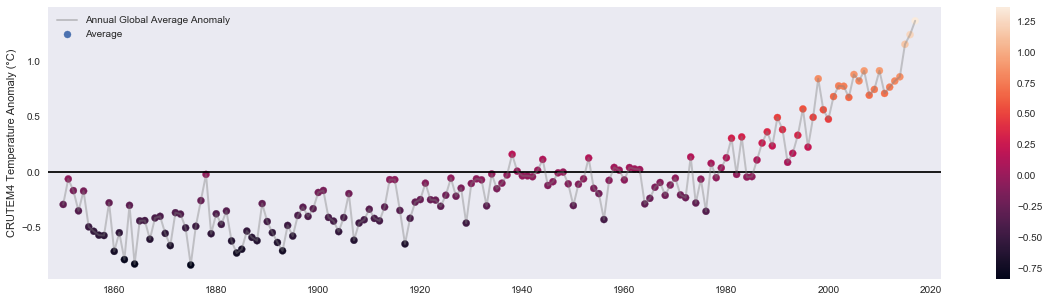

In [96]:
plt.figure(figsize=(20,5))
plt.scatter(pdTemp["Year"], pdTemp["Average"], marker="o", s=50, c=pdTemp["Average"])
plt.plot(pdTemp["Year"], pdTemp["Average"], label="Annual Global Average Anomaly", alpha=0.4, linewidth=2, c="grey")
plt.hlines(0,min(pdTemp["Year"])-3,max(pdTemp["Year"])+5)

plt.legend(loc="best")
plt.xlim(min(pdTemp["Year"])-3, max(pdTemp["Year"])+5)
plt.ylabel(u"CRUTEM4 Temperature Anomaly (\u00B0C)")
plt.colorbar()
plt.grid()
plt.show()

We observe that temperatures seem to be incresing since the 1880sm however other strucutre seems to be present in the time series too, especially there seems to be some kind of oscillation.

## Temperature Data Modelling

### The Models

I will fit two different models to the data: linear and quadratic. In both cases I will assume Gaussian noise. We can express both models mathematically in the following forms:

The linear model with Gaussian additive noise:

\begin{equation}
y_{M_1}(x; \theta) = \theta_0 + \theta_1 x
\end{equation}

\begin{equation}
y \sim \mathcal{N}(y_{M_1}, \sigma_y^2)
\end{equation}

The quadratic model with Gaussian additive noise:

\begin{equation}
y_{M_2}(x; \theta) = \theta_0 + \theta_1 x + \theta_2 x^2
\end{equation}

\begin{equation}
y \sim \mathcal{N}(y_{M_2}, \sigma_y^2)
\end{equation}

###  Maximum likelihood estimation of parameters

Before I apply the estimation routines to the data I need to get into the right form. The numpy array 'data' will consist of three rows, where the first row will contain the years, the second the temperature data and the third an estimate of the variance.

In [97]:
sig = np.var(pdTemp['Average'])
sigma_y = np.shape(pdTemp['Average'])[0]*[sig]
sigma_y = np.array(sigma_y)
data = [[pdTemp['Year'].T], [pdTemp['Average'].T], [sigma_y.T]]
data = np.array(np.squeeze(data))


numpy.ndarray

The following three functions, repsectively, compute the output of model given a $\theta$ parameter vector and an x value; a value for the log likelihood of the data given a medal; and a maximum likelihood estimate for the parameters using a numerical routine.

In [98]:
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

In [99]:
from scipy import stats

def logL(theta, model=polynomial_fit, data=data):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

In [ ]:
from scipy import optimize

def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0] 
    np.shape(theta_0)
    neg_logL = lambda theta: -logL(theta, model, data)
    return optimize.minimize(neg_logL, theta_0, method = 'Nelder-Mead')

Now I find the best model parameters for two model orders.

In [100]:
order_low = 1
order_high = 3
thetaLow = best_theta(order_low)
thetaHigh = best_theta(order_high)


The result of the first model fit:

In [101]:

np.shape(thetaLow)
print(thetaLow)
print(thetaLow.x)

 final_simplex: (array([[ -1.46177262e+01,   7.51080594e-03],
       [ -1.46178009e+01,   7.51084410e-03],
       [ -1.46177886e+01,   7.51083703e-03]]), array([ 15.38580322,  15.38580322,  15.38580323]))
           fun: 15.385803218253095
       message: 'Optimization terminated successfully.'
          nfev: 146
           nit: 79
        status: 0
       success: True
             x: array([ -1.46177262e+01,   7.51080594e-03])
[ -1.46177262e+01   7.51080594e-03]


The results of the second model fit:

In [102]:
thetaHigh
np.shape(thetaHigh)
print(thetaHigh)
print(thetaHigh.x)

 final_simplex: (array([[ -2.35808057e-02,   1.28442988e-01,  -1.36862177e-04,
          3.63930346e-08],
       [ -2.35814267e-02,   1.28445741e-01,  -1.36867091e-04,
          3.63948322e-08],
       [ -2.35874222e-02,   1.28478666e-01,  -1.36900323e-04,
          3.64032209e-08],
       [ -2.35666528e-02,   1.28366366e-01,  -1.36785469e-04,
          3.63738498e-08],
       [ -2.35932570e-02,   1.28510999e-01,  -1.36934670e-04,
          3.64122961e-08]]), array([-39.11940066, -39.11939801, -39.11938116, -39.11937068, -39.11934182]))
           fun: -39.119400660620784
       message: 'Optimization terminated successfully.'
          nfev: 285
           nit: 160
        status: 0
       success: True
             x: array([ -2.35808057e-02,   1.28442988e-01,  -1.36862177e-04,
         3.63930346e-08])
[ -2.35808057e-02   1.28442988e-01  -1.36862177e-04   3.63930346e-08]


In [103]:
print("linear model:    logL =", logL(thetaLow.x))
print("quadratic model: logL =", logL(thetaHigh.x))

linear model:    logL = -15.3858032183
quadratic model: logL = 39.1194006606


We see that the likelihood of the quadratic model is far greater than that of the linear model. However, as we shall soon discuss maximum likelihood cannot be used for model selection because a more complex model will always have a higher likelihood. Though the huge difference in likelihoods between the two models strongly suggests the quadratic model is the correct one. Nevertheless, we carry out a principled frequentist procedure for model selection. First we plot the models found on top the data.

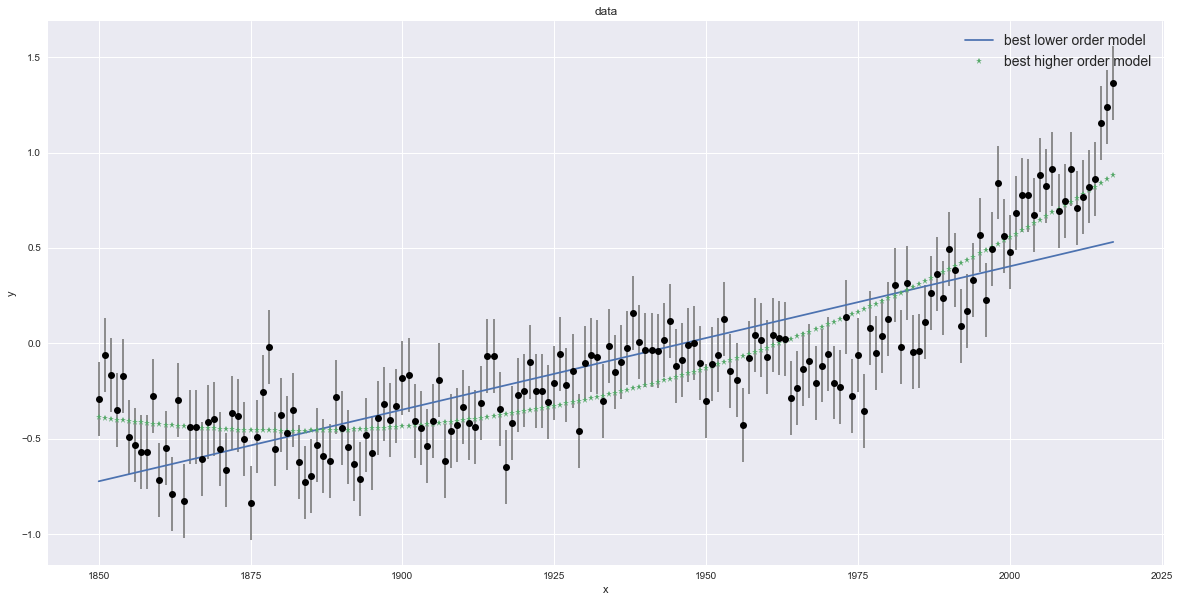

In [104]:
x, y, sigma_y = data
fig, ax = plt.subplots(figsize=(20,10))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(x, polynomial_fit(thetaLow.x, x), label='best lower order model')
ax.plot(x, polynomial_fit(thetaHigh.x, x),'*', label='best higher order model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');
plt.show()



The fits seem very reasonable. Now we need to decide which of these is a better explanation for the data.

## Model Selection

We used the principle of maximum likelihood to obtain the parameters of our models. However, maximum likelihood is unsuited for model selection and it cannot therefore be used to determine which of our two models better fits the temperature anomaly data. The problem with maximum likelihood is that that a more complex model will always have a greater likelihood and as the complexity of the model is increased it will eventually start fitting the noise i.e. over fitting will occur.

### Chi-squared approach to model selection

In the frequentist approach,  estimation is done through deriving a function of the data called a 'statistic' and comparing the value of this statistic for the given data with the distribution of the statistic for the assumed model.  

For both the linear and quadratic models the observed data, $y$, is normally distributed about the model prediction, $y_M$, with variance $sigma_y$. Therefore we can form the following statistics, called the chi-squared statisic, from the data:

\begin{equation}
\chi^2 (D; \theta; M) = \sum_n^N \bigg [ \frac{ y_n - y_M(x_n ;\theta)}{ \sigma_{y,n}} \bigg ] 
\end{equation}

This has the form of the sum of squares of Gaussian distributed values, which is precisely the form of the chi-squared distribution. Therefore we can compare the data with both models by computing the statistics for the data and then locating its value on the chi-squared distribution associated with the model. The chi-squared distribution is in fact a family of distributions rather than a single distribution. Each member of the family is parametarised by the degrees of freedom, which is the number of independent Gaussians in the sum. The degree of freedom is given by $N-K$ where $K$ is the number of parametrs in the model. This number is 2 for the linear model and 3 for the quadratic model.

The following three functions respectively compute the chi-squared value, the degrees of freedom and the chi-squared likelihood of the data given a model.

In [105]:
def compute_chi2(degree, data=data):
    #print(np.shape(y))
    theta = best_theta(degree, data=data)
    resid = (y - polynomial_fit(theta.x, x)) / sigma_y
    return np.sum(resid ** 2)

def compute_dof(degree, data=data):
    #print(data.shape[1] - (degree + 1))
    return data.shape[1] - (degree + 1) # index changed
  

def chi2_likelihood(degree, data=data):
    chi2 = compute_chi2(degree, data)
    dof = compute_dof(degree, data)
    return stats.chi2(dof).pdf(chi2)

print("chi2 likelihood")
print("- linear model:    ", chi2_likelihood(order_low), compute_chi2(order_low))
print("- quadratic model: ", chi2_likelihood(order_high), compute_chi2(order_high))

chi2 likelihood
- linear model:     6.14364489962e-08 273.382503879
- quadratic model:  0.0219510864779 164.372096121


We once again see that the quadratic model is strongly favoured as an explanation of the data. We need to quantify this strength through a significance test. Luckily for us for the case when one model is a special case we can use chi-squared distributions for this through the likelihood ratio test.

### Significance Testing

We need to determine how siginficant the difference in likelihoods between the two models is.

\begin{equation}
f(x ~|~ \theta)
\end{equation}

\begin{equation}
H_0 : \theta_0 \\
H_1: \theta_1
\end{equation}

\begin{equation}
\Lambda (x) = \frac{\cal{L} (\theta_0 ~|~ x)}{\sup \{ \cal{L}(\theta~|~ x ) : \theta \in \{\theta_0, \theta_1\}\}}
\end{equation}

\begin{equation}
\text{if} \Lambda > c do not reject H_0 \\
\text{if} \Lambda < c  reject H_0
\end{equation}

\begin{equation}

\end{equation}

The likelihood ratio is a statistic i.e. a function of the data. The likelihood  ratio test rejects the null hypotheis is the ratio is too small i.e. if the likelihood of the alternative model is significantly greater than that of the null model. Exactly how much more likely the alterntive model must be is determined by the significance level of the test.

#### Procedure

In order to compute the likelihood ratio the optimal parameters for both the null model and alternative model are determined through model fitting procedures and then the log likelihoods are determined. The test statistic, $D$, is obtained from twice the log likelihood rato of the models.

\begin{equation}
D = -2 \ln \frac{( \text{likelihood for null model} )}{ ( \text{likelihood for alternative model})}
\end{equation}

It easily by shown that $D$ is twice the difference in the log likelihoods of the two models.

\begin{equation}
2 \times [ \ln(\text{likelihood for alternative model}) ] - [ \ln(\text{likelihood for null model} )]
\end{equation}

The alternative model is more complex (i.e. has more parameters) than the null model and therefore it will always fit the data as well as the null. Consequently the log likelihood of the alternative model will always be at least as much as that of the null. Whether this difference is significant or not needs to be determined by deriving a p-value. In general when the null is a special case of the alternative model it can be shown that $D$ will be approximately chi-squared distributed. In our problem, however, we have seen that it is exactly chi-squared distributed.

Routine for the likelihood ratio test:

109.010407758
The p value is %d 0.0


C:\Users\jamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


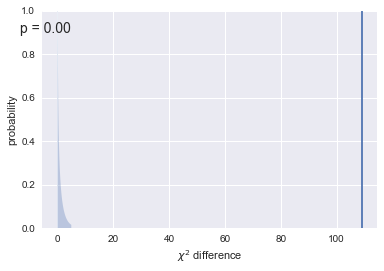

In [106]:
chi2_diff = compute_chi2(order_low) - compute_chi2(order_high)

print(chi2_diff)
print('The p value is %d', p_value)

v = np.linspace(0, 5, 1000)
chi2_dist = stats.chi2(1).pdf(v)
p_value = 1 - stats.chi2(1).cdf(chi2_diff)

fig, ax = plt.subplots()
ax.fill_between(v, 0, chi2_dist, alpha=0.3)
ax.fill_between(v, 0, chi2_dist * (v > chi2_diff), alpha=0.5)
ax.axvline(chi2_diff)
ax.set(ylim=(0, 1), xlabel="$\chi^2$ difference", ylabel="probability");
ax.text(4.9, 0.95, "p = {0:.2f}".format(p_value),
        ha='right', va='top', size=14);
plt.show()

The p-value is extremely small and we therfore find that the linear model is rejected very strongly indeed.

# Conclusion

I eventually found a linear and a quadratic model that fit the data well but an enormous of effort was needed to find the maximum of the likelihood using numerical optimization methods. Gradient based algorithms consistenly became stuck in local minima. And only experimentation with handpicked initial conditions eventually found a solution. Eventually simplex based method found a solution without handpicked initial conditions but even this had difficult and needed a guiding hand. One the the models were fit chi-squared model selection gave a near certain decision in favour of a quadratic rather than a linear model for the data.

# Bibliography

1. Numerical Recipes in C by Press et al. Cambridge Univeristy Press, 1995.